In [1]:
from torchcp.classification.scores import THR, RAPS, APS, SAPS
from torchcp.classification.predictors import SplitPredictor, ClassWisePredictor, ClusterPredictor
from common.dataset import build_dataset
from common.utils import evaluate_plus
from torchcp.utils import fix_randomness
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

fix_randomness(seed=0)

ModuleNotFoundError: No module named 'common'

In [2]:
#######################################
# Loading ImageNet dataset and a pytorch model
#######################################
model_name = 'ResNet101'
model = torchvision.models.resnet101(weights="IMAGENET1K_V1", progress=True)
model_device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model.to(model_device)

dataset = build_dataset('imagenet')

cal_dataset, test_dataset = torch.utils.data.random_split(dataset, [25000, 25000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers=8)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers=8)

In [3]:
#######################################
# A standard process of conformal prediction
#######################################    
alpha = 0.1
print(f"Experiment--Data : ImageNet, Model : {model_name}, Score : THR, Predictor : SplitPredictor, Alpha : {alpha}")
score_function = APS()
predictor = SplitPredictor(score_function, model)
print(f"The size of calibration set is {len(cal_dataset)}.")
predictor.calibrate(cal_data_loader, alpha)

Experiment--Data : ImageNet, Model : ResNet101, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
The size of calibration set is 25000.


In [4]:
# Load OOD dataset
ood_dataset = build_dataset('iNaturalist')
ood_data_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers=8)

# Calc the distribution of size on ID dataset and OOD dataset
id_result_dict = evaluate_plus(predictor, test_data_loader)
ood_result_dict = evaluate_plus(predictor, ood_data_loader)
id_size_list = id_result_dict['All_size']
ood_size_list = ood_result_dict['All_size']

print(f"In-distribution Average_size: {id_result_dict['Average_size']}, Converge_rate {id_result_dict['Coverage_rate']}")

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

In-distribution Average_size: 7.20224, Converge_rate 0.90584


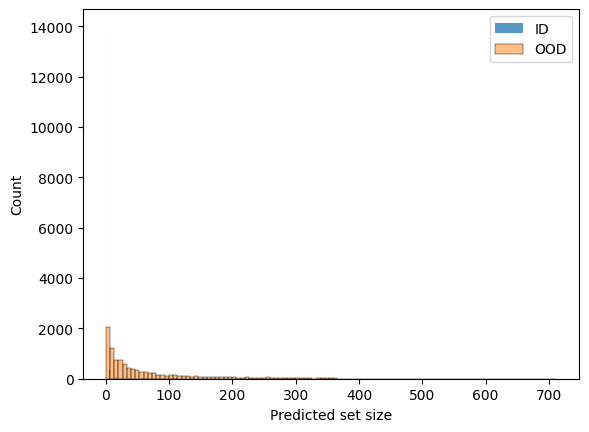

In [8]:
import seaborn as sns
# Distribution of id and ood size
fig, ax = plt.subplots()
sns.histplot(id_size_list, label='ID', ax=ax)
sns.histplot(ood_size_list, label='OOD', ax=ax, alpha=0.5)
ax.set_xlabel('Predicted set size')
# ax.set_xbound(0, 12)
ax.legend()
fig.savefig('fig/dist_aps_split.pdf', bbox_inches='tight')

In [12]:
from torchmetrics import AUROC
auroc = AUROC(task="binary")
# Set 1 as the threshold, do ood dection based on size
id_tf = torch.tensor(np.array(id_size_list) <= 3, dtype=torch.int)
ood_tf = torch.tensor(np.array(ood_size_list) <= 3, dtype=torch.int)
preds = torch.concatenate([id_tf, ood_tf])
id_target = torch.tensor([1 for i in id_tf])
ood_target = torch.tensor([0 for i in ood_tf])
targets = torch.concatenate([id_target, ood_target])
auroc(preds, targets)

tensor(0.5061)

# Plot

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="whitegrid")

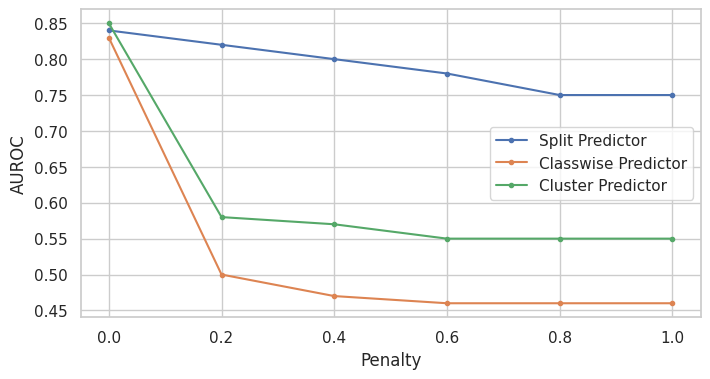

In [2]:
x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y1 = [0.84, 0.82, 0.80, 0.78, 0.75, 0.75]
y2 = [0.83, 0.50, 0.47, 0.46, 0.46, 0.46]
y3 = [0.85, 0.58, 0.57, 0.55, 0.55, 0.55]

fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(x ,y1, marker=".", label="Split Predictor")
ax.plot(x, y2, marker=".", label="Classwise Predictor")
ax.plot(x, y3, marker=".", label="Cluster Predictor")
ax.legend()
ax.set_xlabel("Penalty")
ax.set_ylabel("AUROC")
fig.savefig("./fig/penalty.pdf", bbox_inches="tight")